## BERTScore Tutorial

### Installation
if you have not installed `bert_score`, it is very easy
simply uncomment the line below to install through pip

In [1]:
#!pip install bert_score

In [3]:
# check your installation
import bert_score
bert_score.__version__

'0.3.6'

### preparation

In [2]:
# hide the loading messages
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["xtick.major.size"] = 0
rcParams["xtick.minor.size"] = 0
rcParams["ytick.major.size"] = 0
rcParams["ytick.minor.size"] = 0

rcParams["axes.labelsize"] = "large"
rcParams["axes.axisbelow"] = True
rcParams["axes.grid"] = True

## Function API

We will first demonstrate how to use the `score` function in `bert_score`, which is what you need to evaluate a set of machine generated outputs.

In [10]:
from bert_score import score

Inputs to `score` are a list of candidate sentences and a list of reference sentences. 

In [2]:
with open("hyps.txt") as f:
    cands = [line.strip() for line in f]

with open("refs.txt") as f:
    refs = [line.strip() for line in f]

Let's have a look.

In [3]:
cands[0]

'28-year-old chef found dead in San Francisco mall'

We are now ready to call the score function. Besides candidates and references, we need to speicify the bert model we are using. Since we are dealing with English sentences, we will use the *bert-base-uncased* model.

In [4]:
P, R, F1 = score(cands, refs, lang='en', verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]calculating scores...
computing bert embedding.
100%|██████████| 1/1 [00:00<00:00, 98.94it/s]computing greedy matching.
done in 3.57 seconds, 2.80 sentences/sec



The outputs of the `score` function are Tensors of precision, recall, and F1 respectively. Each Tensor has the same number of items with the candidate and reference lists. Each item in the list is a scalar, representing the score for the corresponding candidates and references.

In [5]:
F1

tensor([0.9834, 0.9782, 0.9162, 0.9589, 0.9675, 0.9680, 0.9602, 0.9663, 0.9438,
        0.9508])

We can take the average of all candidate reference pairs to be the system level score.

In [6]:
print(f"System level F1 score: {F1.mean():.3f}")

System level F1 score: 0.959


It might also be very interestig to see the distribution of BERTScore.

In [7]:
import matplotlib.pyplot as plt

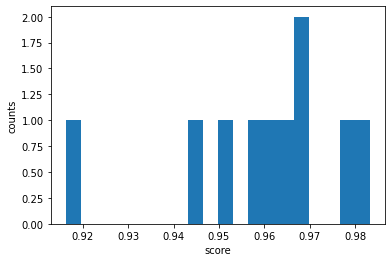

In [8]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

Some contextual embedding models, like RoBERTa, often produce BERTScores in a very narrow range (as shown above, the range is roughly between 0.92 and 1). Although this artifact does not affect the ranking ability of BERTScore, it affects the readability. Therefore, we propose to apply "baseline rescaling" to adjust the output scores. More details on this feature can be found in [this post](https://github.com/Tiiiger/bert_score/blob/master/journal/rescale_baseline.md).

In [6]:
P, R, F1 = score(cands, refs, lang='en', rescale_with_baseline=True)

NameError: name 'cands' is not defined

We can now see that the scores are much more spread out, which makes it easy to compare different examples.

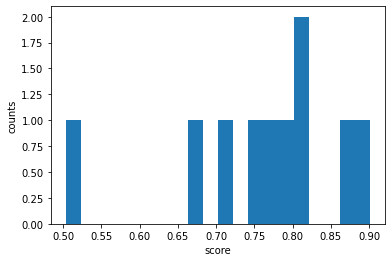

In [10]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

The `score` function also handles multiple references gracefully. Consider a candidate sentences with 3 references.

In [11]:
single_cands = ['I like lemons.']
multi_refs = [['I am proud of you.', 'I love lemons.', 'Go go go.']]

In [14]:
P_mul, R_mul, F_mul = score(single_cands, multi_refs, lang="en", rescale_with_baseline=True)

The `score` function will return the best score among all the references automatically.

In [15]:
F_mul

tensor([0.9025])

To understand a text generation system better, we can visualize the matchings in BERTScore.

In [14]:
from bert_score import plot_example

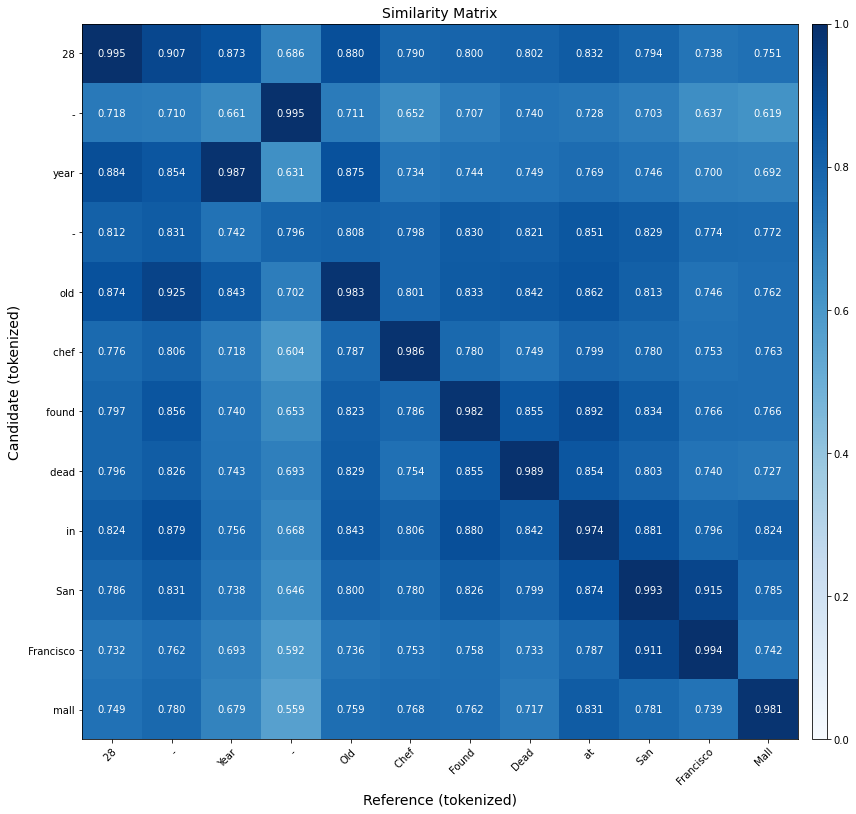

In [15]:
plot_example(cands[0], refs[0], lang="en")

Similarly, we can apply rescaling to adjust the similarity distribution to be more distinguishable.

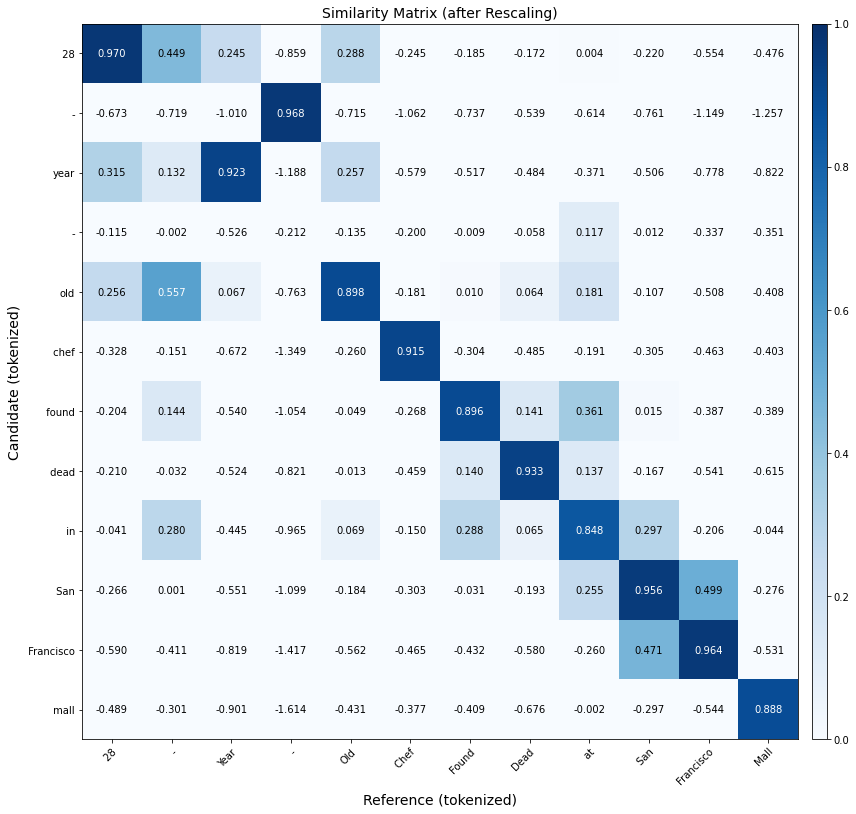

In [16]:
plot_example(cands[0], refs[0], lang="en", rescale_with_baseline=True)

## Object-oriented API

In practice, most of the time of calling the `score` function is spent on building the model. In situations when we want to call the `score` function repeatedly, it is better to cache the model in a `scorer` object. Hence, in `bert_score` we also provide an object-oriented API. 

The `BERTScorer` class provides the two methods we have introduced above, `score` and `plot_example`.

In [47]:
from bert_score import BERTScorer

In [48]:
scorer = BERTScorer(lang="en", rescale_with_baseline=True)

#### 自定义cands  refs

**格式**
```
cands = ['I like lemons.','cands2']
refs = [['I love lemons.','2','3'],'ref2']

```

In [104]:
cands = ['Apple']
refs = ['apple']

In [105]:
P, R, F1 = scorer.score(cands, refs)

In [106]:
F1

tensor([0.9981])

In [ ]:
scorer.plot_example(cands[0], refs[0])